In [2]:
import os
import sys
import pandas as pd
import numpy as np
import glob
import time
import gget
import scipy
import scanpy as sc
import anndata as an
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from importlib import reload

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import plotting as plt2

In [4]:
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/single_cell_hypergraph_mt/combined_u.pkl"
df = pd.read_pickle(fpath)
print(f"{df.shape=}")
df.head()

df.shape=(17186, 130)


,o3b50,o3b43,o1b04,o3b38,o1b59,o4b67,o3b54,o1b96,o1b22,o3b56,...,o3b26,o2b16,o4b46,o2b74,o4b84,o2b18,o2b96,o2b23,o1b15,o1b50
Smarca2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sh2d5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Dyrk1a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Igf2bp3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tmem267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Cluster single-cells

Preprocessing...
Computing nearest neighbors...
Running Leiden clustering...
Detected 7 clusters.
Computing UMAP embedding...


... storing 'sample' as categorical


Generating UMAP plot...


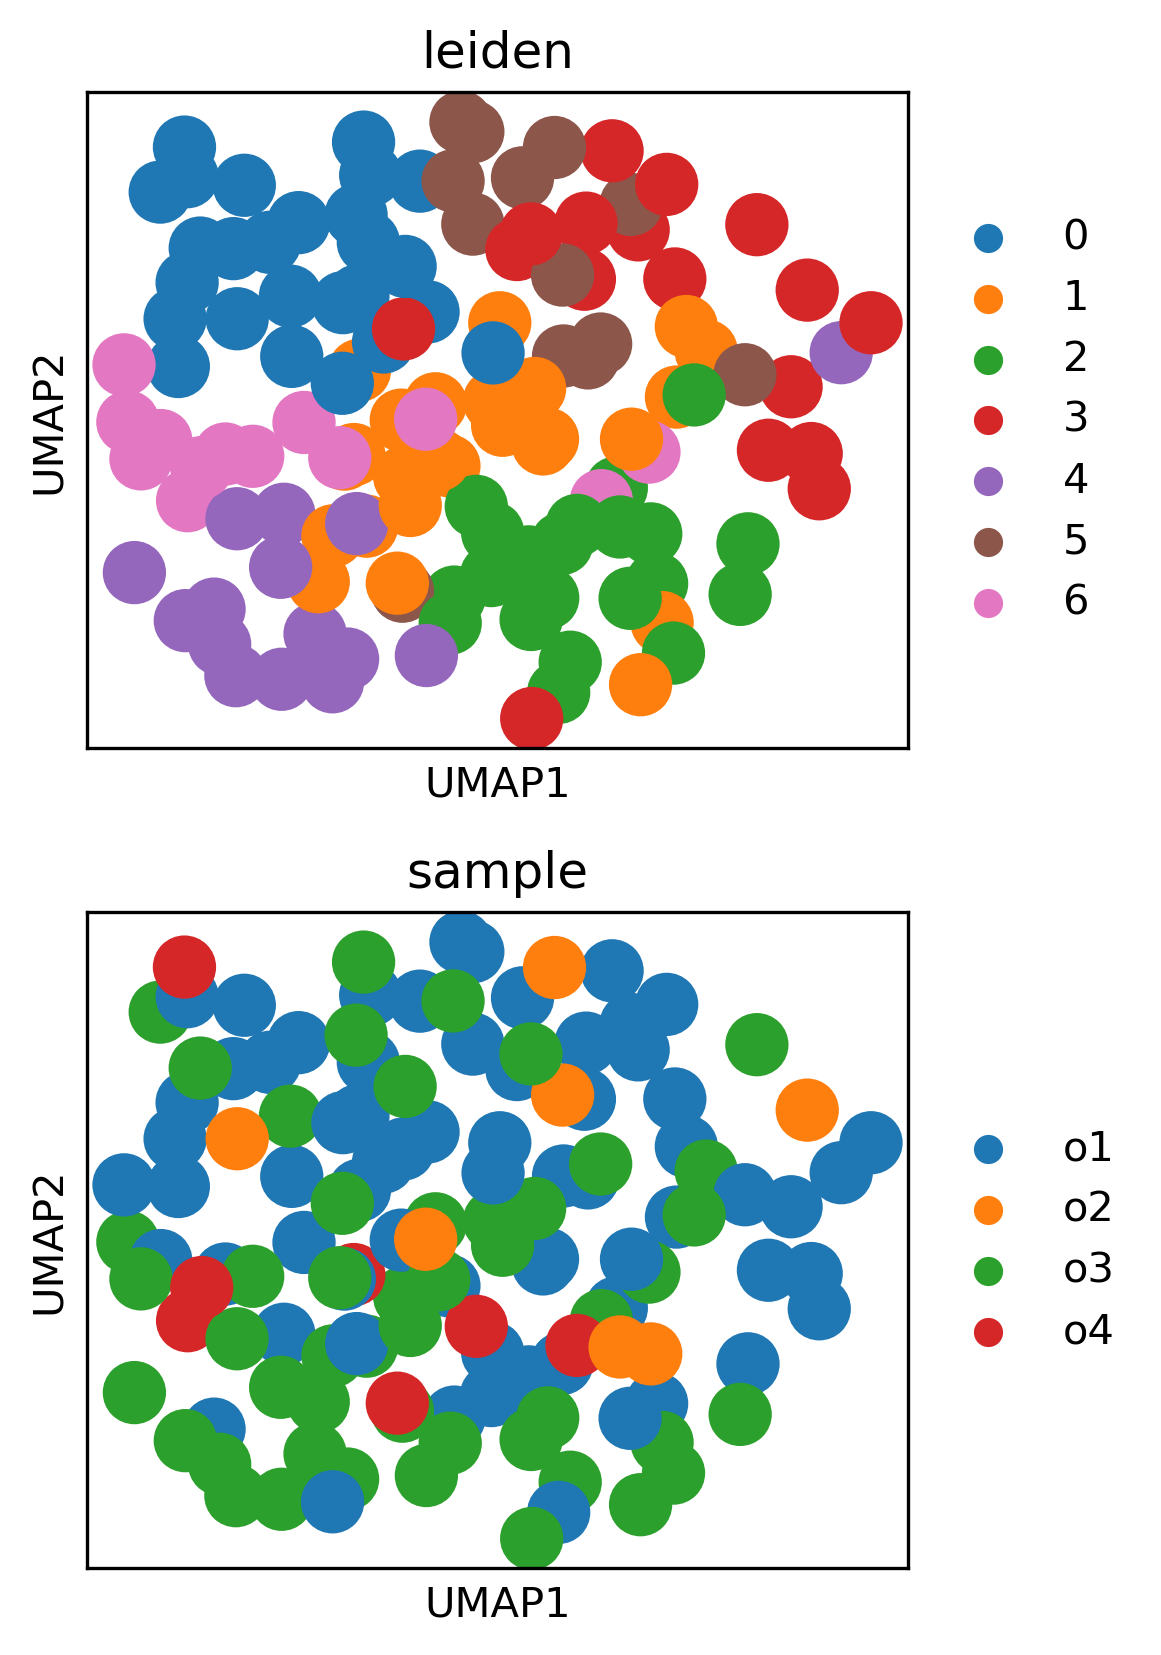

In [61]:
# create anndata
adata = an.AnnData(
    X=df.T
)

adata.obs['sample'] = adata.obs.index.str[:2]
adata.layers['raw'] = adata.X.copy()

print("Preprocessing...")
sc.pp.normalize_total(adata, target_sum=1)
sc.pp.pca(adata)

print("Computing nearest neighbors...")
sc.pp.neighbors(adata, n_neighbors=5,)

print("Running Leiden clustering...")
sc.tl.leiden(adata, resolution=0.85)
print(f"Detected {adata.obs['leiden'].nunique()} clusters.")
adata.obs['cluster_label'] = adata.obs['leiden'].apply(lambda x: f"C{int(x) + 1} ")

print("Computing UMAP embedding...")
sc.tl.umap(
    adata,
    # min_dist=0.05,
)

adata.obs['UMAP 1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP 2'] = adata.obsm['X_umap'][:, 1]

print("Generating UMAP plot...")
sc.pl.umap(
    adata,
    color=["leiden", 'sample'],
    ncols=1,
)

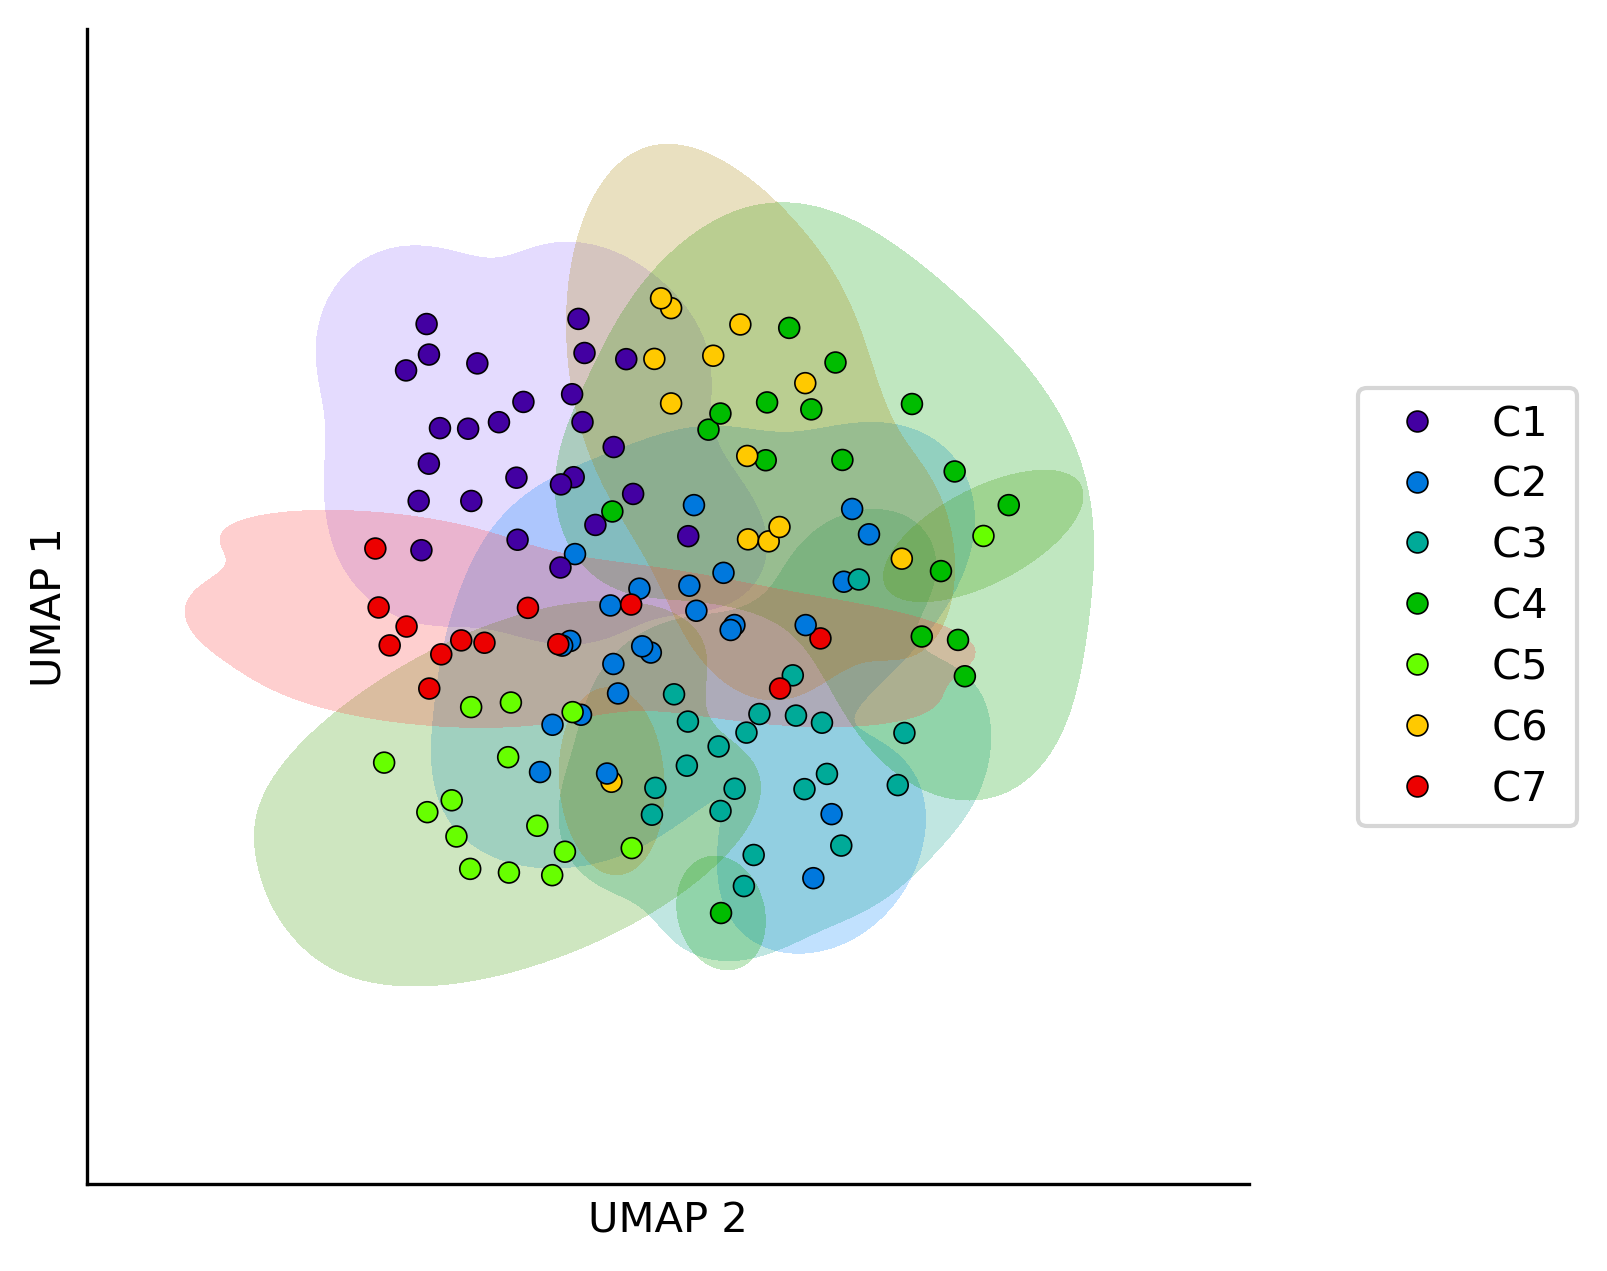

In [67]:
pdf = adata.obs.copy()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

# Plot the contours
sns.kdeplot(
    data=pdf,
    x='UMAP 1',
    y='UMAP 2',
    hue='cluster_label',
    palette='nipy_spectral',
    alpha=0.25,  # Adjust transparency
    levels=2,  # Adjust number of contour levels
    fill=True  # Fill the contours
)

sns.scatterplot(
    data=pdf,
    x='UMAP 1',
    y='UMAP 2',
    hue='cluster_label',
    s=25,
    ec='k',
    palette='nipy_spectral'
)

plt.ylabel("UMAP 1")
plt.xlabel("UMAP 2")
plt.xticks([])
plt.yticks([])
sns.despine()
sns.move_legend(
    plt.gca(),
    title="",
    loc='center right',
    bbox_to_anchor=(1.3, 0.5)
)

In [78]:
sc.tl.rank_genes_groups(
    adata, 
    groupby="cluster_label",
    method='wilcoxon',
    corr_method='benjamini-hochberg',
    pts=True,
)

deg = sc.get.rank_genes_groups_df(
    adata, 
    group=None,
)

deg = deg.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False])
deg.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
411,C1,St8sia3,0.30266,21.020727,0.762149,1.0,0.038462,0.0
150,C1,Atg4b,0.60532,20.757469,0.544966,1.0,0.076923,0.0
67,C1,Gm4847,0.90798,20.728086,0.363889,1.0,0.115385,0.0
66,C1,D130040H23Rik,0.90798,20.605780,0.363889,1.0,0.115385,0.0
393,C1,Glo1,0.30266,20.548262,0.762149,1.0,0.038462,0.0


In [107]:
aggdata = sc.get.aggregate(
    adata,
    by='cluster_label',
    axis='obs',
    func='mean',
)

aggdata = aggdata.to_df(layer='mean').reset_index(drop=False)
aggdata = pd.melt(aggdata, id_vars='index')
aggdata.head()

aggdata = aggdata.sort_values(by=['index', 'value'], ascending=[True, False])
aggdata.head()

,index,variable,value
12999,C1,Bax,0.007423
87871,C1,Gvin1,0.006268
686,C1,Lrp1b,0.005929
59213,C1,Crim1,0.005708
12096,C1,Myo1f,0.005453


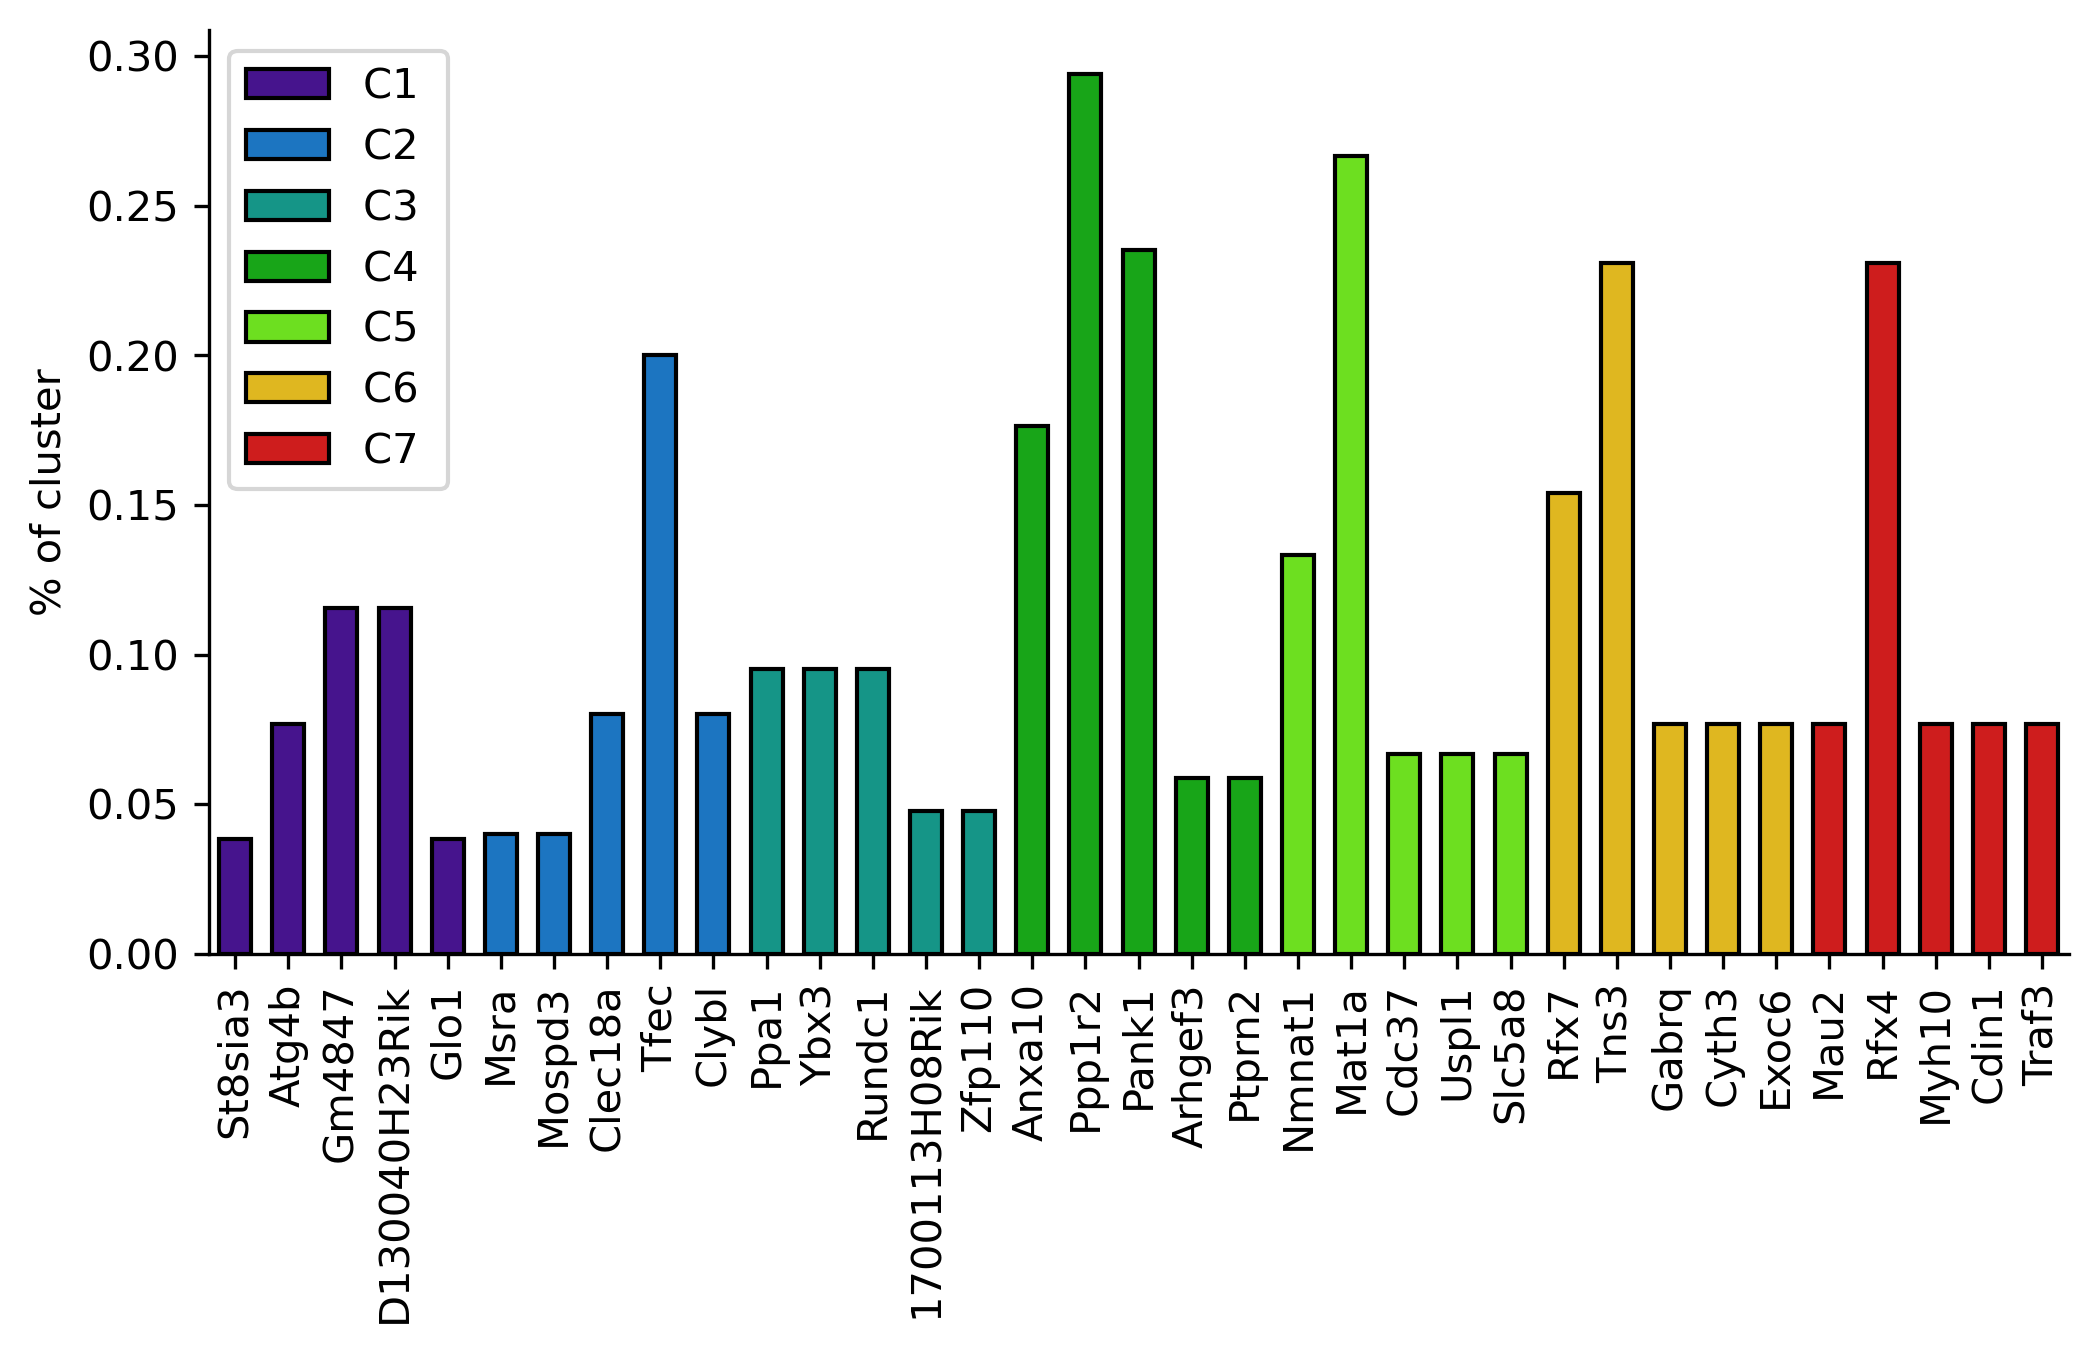

In [116]:
pdf = deg.groupby('group').head(5)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 4

sns.barplot(
    data=pdf,
    x='names',
    y='pct_nz_group',
    hue='group',
    ec='k',
    palette='nipy_spectral',
    width=0.6,
)

plt.ylabel("% of cluster")
plt.xlabel("")

plt.gca().tick_params(axis='x', rotation=90)
sns.despine()

sns.move_legend(
    plt.gca(),
    title="",
    loc='best'
)

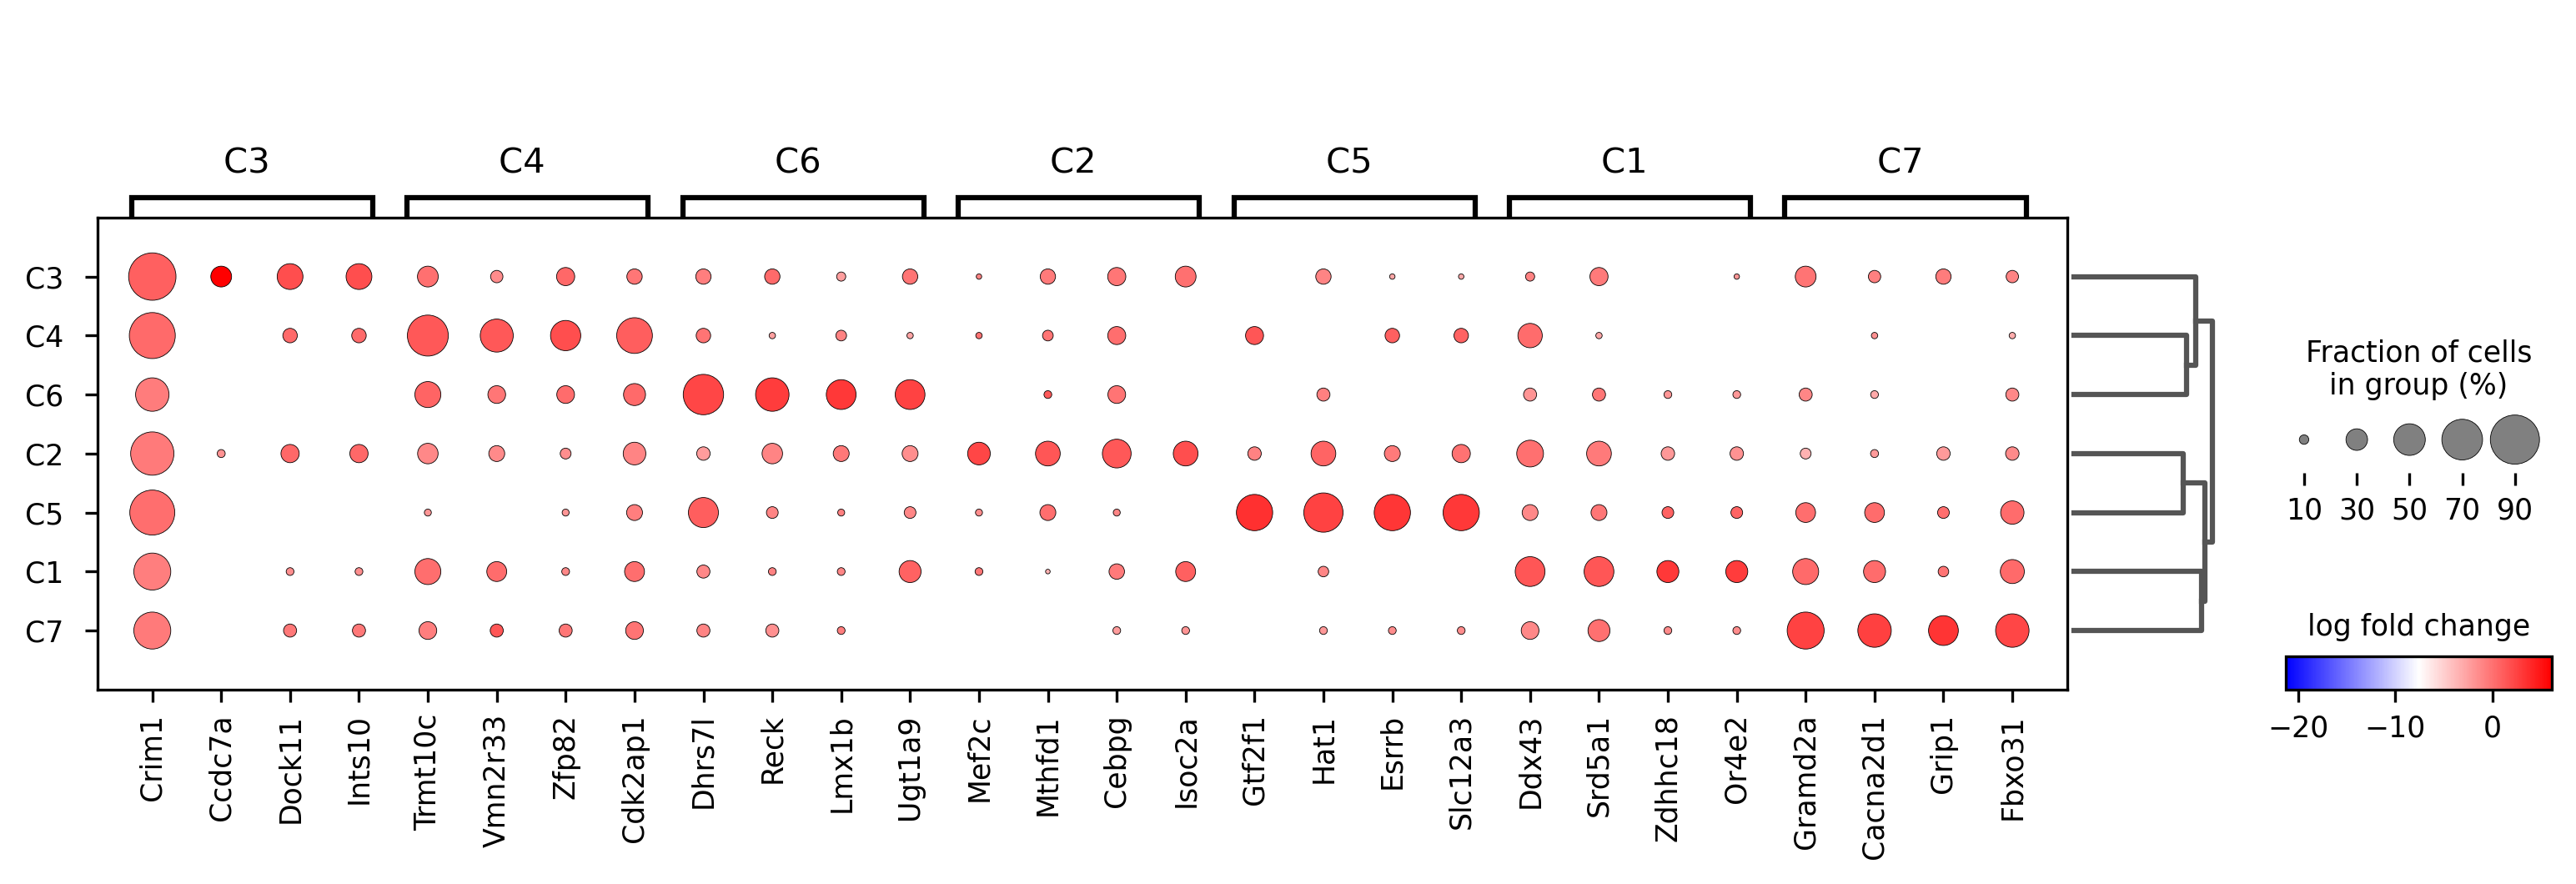

In [83]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    n_genes=4,
    values_to_plot="logfoldchanges",
    cmap="bwr",
)

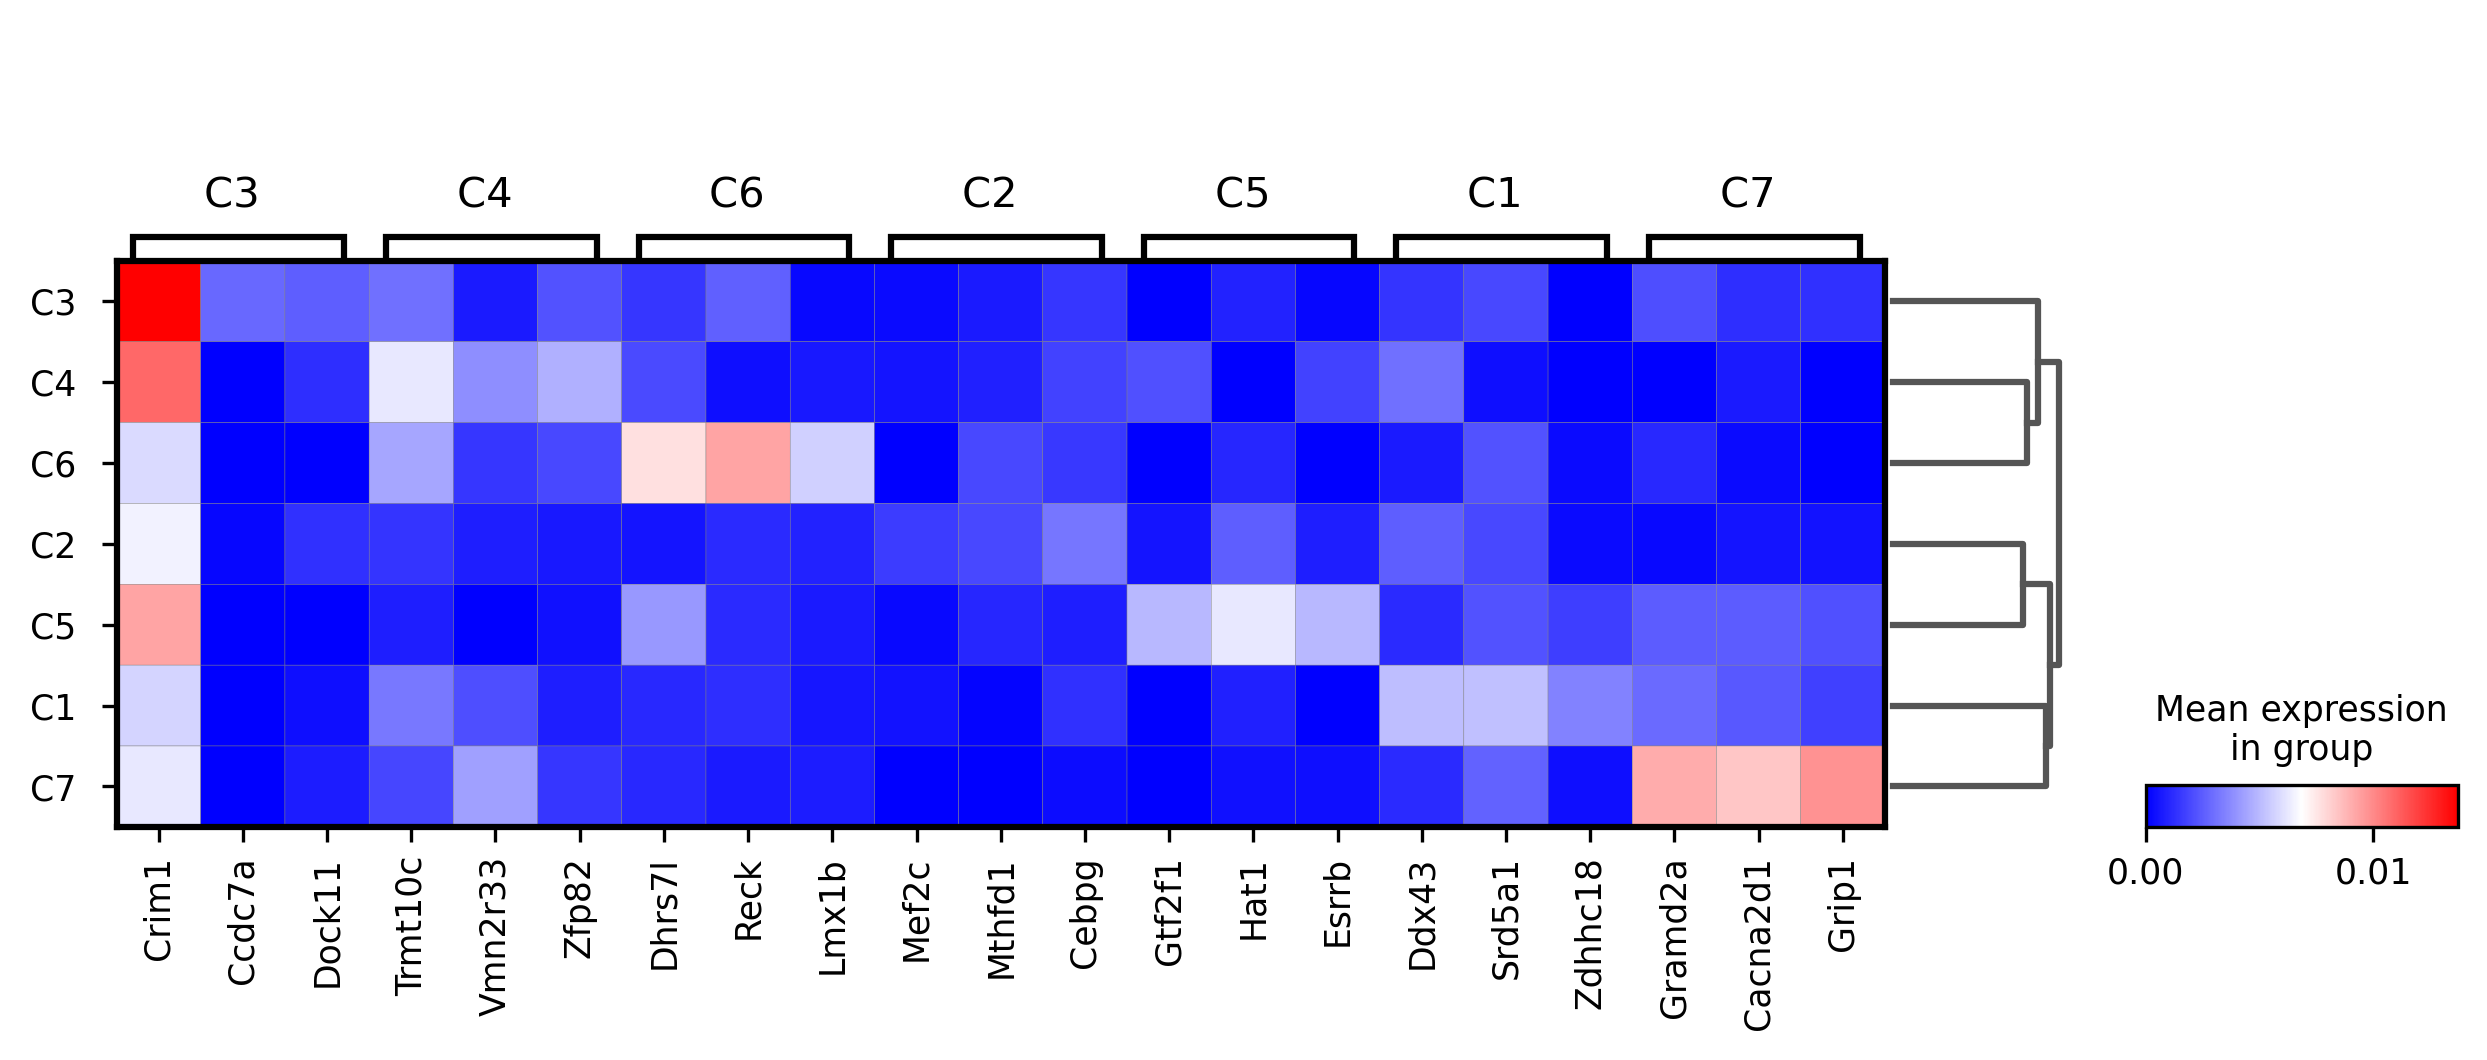

In [82]:
sc.pl.rank_genes_groups_matrixplot(
    adata, n_genes=3, 
    use_raw=False, 
    cmap="bwr", 
)

In [75]:
pdf = deg.groupby('group').head(2)


sns.scatterplot(
    data=pdf,
    x=''
)

,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
411,C1,St8sia3,0.302660,21.020727,0.762149,1.0,0.038462,0.0
150,C1,Atg4b,0.605320,20.757469,0.544966,1.0,0.076923,0.0
18123,C2,Msra,0.310134,20.988728,0.756459,1.0,0.040000,0.0
18471,C2,Mospd3,0.310134,20.988728,0.756459,1.0,0.040000,0.0
34480,C3,Ppa1,0.689539,21.790049,0.490484,1.0,0.095238,0.0
34473,C3,Ybx3,0.689539,21.619467,0.490484,1.0,0.095238,0.0
51596,C4,Anxa10,1.170472,21.441372,0.241811,1.0,0.176471,0.0
51566,C4,Ppp1r2,1.950786,21.240747,0.051082,1.0,0.294118,0.0
68828,C5,Nmnat1,0.838027,21.111557,0.402015,1.0,0.133333,0.0
68768,C5,Mat1a,1.676055,20.994450,0.093727,1.0,0.266667,0.0
